In [1]:
!pip install datasets
!pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


In [2]:
!ls ./drive/MyDrive

 232020MAT1__MARTI_PEREZ_firmado.pdf			       Justificante_17572749.pdf
 26579566F_FÉLIX_MARTÍ_ciudadano_1644506302753.p12	       Orux
 Bd							       Pasta_Tour.docx
'Colab Notebooks'					      'Personal_monthly_budget .xlsx'
 Dataset						       Resume.gdoc
 Docubox_19-09-2022_1231.pdf				      'Untitled document.gdoc'
 felix-Protocolo-de-actuacion-Certificado-Entorno-Seguro.pdf


In [3]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import torch
import glob
import json
from PIL import Image
from patchify import patchify

In [4]:
def json_to_mask(json_file, image_shape=(750, 1000)):
    mask = np.zeros(image_shape, dtype=np.uint8)
    #print(mask.shape)
    #print(json_file[0]['content'])
    pts = []
    if len(json_file[0]['content']) == 0:
        return mask
    for point in json_file[0]['content']:
        if json_file[0]['contentType'] == 'polygon':
            #print(point['x'], point['y'])
            x,y = int(point['x']), int(point['y'])
            #print(mask[y,x])
            pts.append([x,y])
    #print(mask.shape)
    pts = np.array(pts, np.int32)
    mask = cv2.fillPoly(mask, pts=[pts], color=255)
    return mask

In [5]:
image_files = sorted(glob.glob("./drive/MyDrive/Dataset/images/*.jpg"))
mask_files = sorted(glob.glob("./drive/MyDrive/Dataset/masks/*.json"))

In [6]:
from PIL import Image

images = [cv2.imread(file) for file in image_files]
masks = [json_to_mask(json.load(open(file))) for file in mask_files]

images = np.array(images)
masks = np.array(masks)

In [7]:
print(images.shape)
print(masks.shape)
#print(images[0].dtype)
#print(masks[0].dtype)

(930, 750, 1000, 3)
(930, 750, 1000)


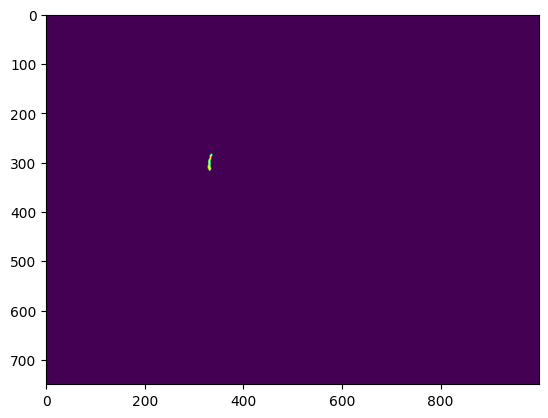

In [8]:
#plt.imshow(images[0])
plt.imshow(masks[0])

In [9]:
def patchify_dataset(images, patch_size=(250,250, 3), step=250):
    #Return patchified images and masks as numpy arrays
    patch_images = []
    for i in range(images.shape[0]):
        #print(images[i].shape)
        #print(mask.shape)
        patch_images.append(patchify(images[i], patch_size, step))
        #patch_masks.append(patchify(mask, patch_size, step))
    patch_images = np.array(patch_images)
    #patch_masks = np.array(patch_masks)
    if len(patch_size) == 3:
      patch_images = np.reshape(patch_images, (-1, patch_size[0], patch_size[1], patch_size[2]))
    elif len(patch_size) == 2:
      patch_images = np.reshape(patch_images, (-1, patch_size[0], patch_size[1]))
    return patch_images

In [10]:
#patch_images, patch_masks = patchify_dataset(images, masks)
patch_images = patchify_dataset(images)
patch_masks = patchify_dataset(masks, patch_size=(250,250))
print(patch_images.shape)
print(patch_masks.shape)

(11160, 250, 250, 3)
(11160, 250, 250)


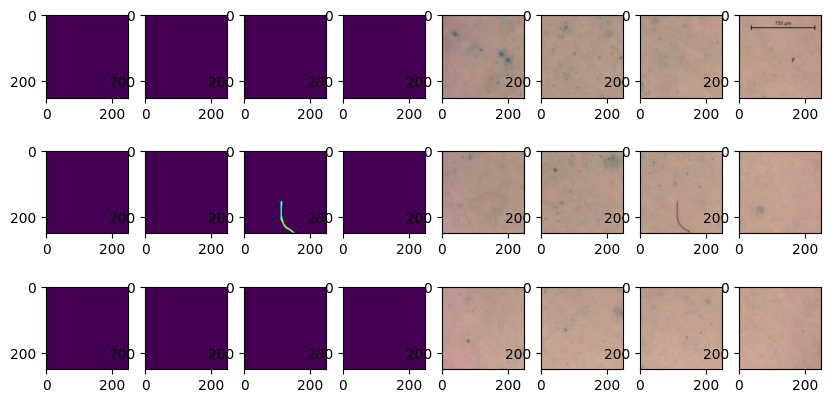

In [11]:
fig, axes = plt.subplots(3, 8, figsize=(10, 5))
i=12*4
axes[0][0].imshow(patch_masks[0+i])
axes[0][1].imshow(patch_masks[1+i])
axes[0][2].imshow(patch_masks[2+i])
axes[0][3].imshow(patch_masks[3+i])
axes[0][4].imshow(patch_images[0+i])
axes[0][5].imshow(patch_images[1+i])
axes[0][6].imshow(patch_images[2+i])
axes[0][7].imshow(patch_images[3+i])
axes[1][0].imshow(patch_masks[4+i])
axes[1][1].imshow(patch_masks[5+i])
axes[1][2].imshow(patch_masks[6+i])
axes[1][3].imshow(patch_masks[7+i])
axes[1][4].imshow(patch_images[4+i])
axes[1][5].imshow(patch_images[5+i])
axes[1][6].imshow(patch_images[6+i])
axes[1][7].imshow(patch_images[7+i])
axes[2][0].imshow(patch_masks[8+i])
axes[2][1].imshow(patch_masks[9+i])
axes[2][2].imshow(patch_masks[10+i])
axes[2][3].imshow(patch_masks[11+i])
axes[2][4].imshow(patch_images[8+i])
axes[2][5].imshow(patch_images[9+i])
axes[2][6].imshow(patch_images[10+i])
axes[2][7].imshow(patch_images[11+i])

In [12]:
print(patch_masks[0].max())

0


In [13]:
valid_indices = [i for i, patch_mask in enumerate(patch_masks) if patch_mask.max() != 0]
filtered_images = patch_images[valid_indices]
filtered_masks = patch_masks[valid_indices]
print("Image shape:", filtered_images.shape)
print("Mask shape:", filtered_masks.shape)

#filtered_images = patch_images
#filtered_masks = patch_masks

Image shape: (1013, 250, 250, 3)
Mask shape: (1013, 250, 250)


In [14]:
dataset_dict = {
    "image": [Image.fromarray(image) for image in filtered_images],
    "mask": [Image.fromarray(mask, mode='L') for mask in filtered_masks]
}

In [15]:
from datasets import Dataset

dataset = Dataset.from_dict(dataset_dict)

In [16]:
dataset

Dataset({
    features: ['image', 'mask'],
    num_rows: 1013
})

202


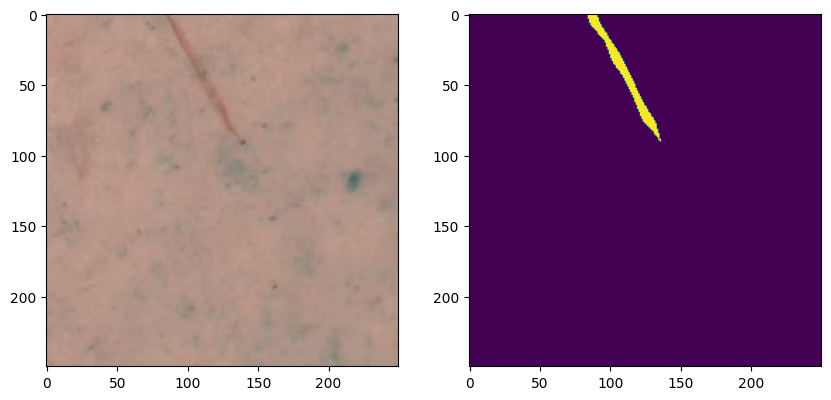

In [32]:
img_num = random.randint(0, filtered_images.shape[0]-1)
print(img_num)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(dataset[img_num]["image"])
axes[1].imshow(dataset[img_num]["mask"])

In [18]:
dataset.save_to_disk("train_929img_new")

Saving the dataset (0/1 shards):   0%|          | 0/1013 [00:00<?, ? examples/s]